# Objective: Which Hotel to recommend?
In this work, I create a recommendation system that ask customers about some their options, then suggest them best one. My goal for this project is to accurately match customers with hotel inventory in highly competitive market.

I would recommend hotels with the largest similarity to the user request. This recommender system is highly dependent on defining an appropriate similarity measure. Eventually, I select a subset of hotels to for training  and to determine an order in which to display the hotels.

This hotel recommender engine is a model-based Content-Based(CB) recommendation system. In other words, I extracted some information from the dataset, and use that as a “model” to make recommendations without having to use the complete dataset every time. This approach offers the benefits of both speed and scalability.

After some preprocessing and feature engineering, I used Kmeans method to cluster information of 10 hotels for one year. Then, for all, I predict the cluster for all hotels in Berlin.

For recommendation, after gathering information from user, the most similar cluster will be offered. Hotels in suggestion will be sorted by the maximum similarity to the user request.

## Data
* exercise.csv: information about prices of several (~ 4 million rows)
hotels for the next year 
* clean_data_1394_berlin.csv: a snapshot for the whole city of Berlin (~60 million rows).

Analysing huge csv files is not possible on my laptop, so I use 1M rows of each file and I used Dask dataframe for 
parallel computing to handel huge dataset.

## Steps
* Step 0: install python packages and import packages
* Step 1: reading huge csv file as dask and pandas dataframe.
* Step 2: choosing some feature of exercise.csv file
* Step 3: using Elbow Curve to find the best choise for number of clusters
* Step 4: Kmeans clustering for  data extracted from exercise.csv  
* Step 5: predicing label of cluster for all Hotels in Berlin
* Step 6: asking a user about his/her choise
* Step 7: recommending for a user by finding the most similar cluster to his/her request
    

## Software Prerequisites
* Python 3+
* Linux Ubuntu 16.04

## Install Python Packages

In [ ]:
#!pip install dask
#!pip install pandas
#!pip install cloudpickle
#!pip install dask[dataframe] --upgrade

## Import Package 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

## Import Data

In [2]:
# read data using pandas as a dataframe
df1 = pd.read_csv("exercise.csv", nrows=1000000)

In [3]:
df1.head()

,Unnamed: 0,channelId,hotelId,price,targetDate,updatedAt,rateName,los,roomType,currency,isSoldout,isCancelable,mealPlan,leadTime,occupancy,snapshotDate
0,0,4,952,210.61,2019-12-17,2019-12-17 00:12:26Z,Deluxe Apartment mit 2 Schlafzimmern und Balko...,1,Deluxe Apartment,EUR,False,True,RoomOnly,0,3,2019-12-17
1,1,4,39,494.00,2019-12-17,2019-12-17 08:43:06Z,Deluxe Suite - Stornierung Kostenfrei,1,Doppelzimmer,EUR,False,True,InclBreakfast,0,3,2019-12-17
2,2,4,39,449.00,2019-12-17,2019-12-17 08:43:06Z,Deluxe Suite - Stornierung Kostenfrei,1,Doppelzimmer,EUR,False,True,RoomOnly,0,3,2019-12-17
3,3,4,39,429.00,2019-12-17,2019-12-17 08:43:06Z,Deluxe Suite - Stornierung Kostenfrei,1,Doppelzimmer,EUR,False,True,InclBreakfast,0,2,2019-12-17
4,4,4,39,399.00,2019-12-17,2019-12-17 08:43:06Z,Deluxe Suite - Stornierung Kostenfrei,1,Doppelzimmer,EUR,False,True,RoomOnly,0,2,2019-12-17


In [4]:
# print unique values of each column to gain high level perspective of the data
for col_name in df1.columns:
        unique_cat = len(df1[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))
        print("They are:", df1[col_name].unique(), '\n' )

Feature 'Unnamed: 0' has 13273 unique categories
They are: [    0     1     2 ... 13044 10706 10524] 

Feature 'channelId' has 1 unique categories
They are: [4] 

Feature 'hotelId' has 10 unique categories
They are: [   952     39    157    244   1628   1971   5503   5508  79096 782999] 

Feature 'price' has 4393 unique categories
They are: [210.61 494.   449.   ... 342.9  249.85 245.1 ] 

Feature 'targetDate' has 107 unique categories
They are: ['2019-12-17' '2019-12-18' '2019-12-19' '2019-12-20' '2019-12-21'
 '2019-12-22' '2019-12-23' '2019-12-24' '2019-12-25' '2019-12-26'
 '2019-12-27' '2019-12-28' '2019-12-29' '2019-12-30' '2020-01-01'
 '2020-01-02' '2020-01-03' '2020-01-04' '2020-01-05' '2020-01-06'
 '2020-01-07' '2020-01-10' '2020-01-11' '2020-01-12' '2020-01-13'
 '2020-01-14' '2020-01-15' '2020-01-16' '2020-01-17' '2020-01-18'
 '2020-01-19' '2020-01-20' '2020-01-21' '2020-01-22' '2020-01-23'
 '2020-01-24' '2020-01-25' '2020-01-26' '2020-01-27' '2020-01-28'
 '2020-01-29' '2020-01

They are: [False] 

Feature 'isCancelable' has 2 unique categories
They are: [ True False] 

Feature 'mealPlan' has 2 unique categories
They are: ['RoomOnly' 'InclBreakfast'] 

Feature 'leadTime' has 217 unique categories
They are: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18
  19  20  21  24  25  26  27  28  29  30  31  33  34  35  36  37  38  40
  41  43  44  45  46  47  48  51  52  53  54  55  56  57  58  59  60  22
  23  32  39  42  61  49  50  14  88 266 267  62  67 279 280 281 282 283
 284 285 286 287 288 289 290 291 292 293  89 124  95  63 113 114 115 116
 117 118 119 120 121 122 123 125 126 127  66  70  71  72  64  65  69  68
  84  85  86  87  75  73  74  76  77  78  79  80  81  82  83  92  93  96
  97  98  99 100 101 102 103 104 105 106 107  90  91  94 243 250 110 191
 198 236 108 109 111 112 132 134 128 129 130 131 133 278 277 260 276 259
 275 274 273 170 294 295 296 297 298 299 184 272 262 271 270 253 269 252
 268 257 255 208 265 264 263 136 137 1


Identify a room:
* A price for a particular room usually changes in time, so one room can have several entries with differet
updated values. if two rows are the same in all features except updatedAt, I keep just one of them. 
* "hotelid" + "rateName" are enough to identify a room after removing duplications.

In [5]:
df1.drop(["updatedAt", "snapshotDate"], axis=1, inplace=True)

In [6]:
# check duplicated rows
print("number of duplicated rows", sum(df1.duplicated(df1.columns)))

number of duplicated rows 15695


In [8]:
# dropping duplicate values 
df1.drop_duplicates(inplace=True)

In [9]:
df1.shape

(984305, 14)

## Feature Engineering

In [10]:
# Extrac some feature for time
df1['targetDate']= pd.to_datetime(df1.targetDate)
df1["month"] = df1["targetDate"].dt.month
df1["day_of_week"] = df1["targetDate"].dt.dayofweek
df1["day_of_month"] = df1["targetDate"].dt.day

In [11]:
# selecting some important features
df1 = df1.drop(["currency", "isSoldout", "channelId", "targetDate",'Unnamed: 0'], axis=1)

In [12]:
# save data to load easier (huge csv file) in next steps
df1.to_csv("exercise1.csv", index=False)

In [14]:
# load data using dask (parallel computing)
df1 = dd.read_csv("exercise1.csv")
df1.head()

,hotelId,price,rateName,los,roomType,isCancelable,mealPlan,leadTime,occupancy,month,day_of_week,day_of_month
0,952,210.61,Deluxe Apartment mit 2 Schlafzimmern und Balko...,1,Deluxe Apartment,True,RoomOnly,0,3,12,1,17
1,39,494.00,Deluxe Suite - Stornierung Kostenfrei,1,Doppelzimmer,True,InclBreakfast,0,3,12,1,17
2,39,449.00,Deluxe Suite - Stornierung Kostenfrei,1,Doppelzimmer,True,RoomOnly,0,3,12,1,17
3,39,429.00,Deluxe Suite - Stornierung Kostenfrei,1,Doppelzimmer,True,InclBreakfast,0,2,12,1,17
4,39,399.00,Deluxe Suite - Stornierung Kostenfrei,1,Doppelzimmer,True,RoomOnly,0,2,12,1,17


In [15]:
# list of columns 
df1.columns

Index(['hotelId', 'price', 'rateName', 'los', 'roomType', 'isCancelable',
       'mealPlan', 'leadTime', 'occupancy', 'month', 'day_of_week',
       'day_of_month'],
      dtype='object')

In [16]:
# size of dataset
df1.compute().shape

(984305, 12)

In [17]:
# function for encode categorical variable in dask dataframe
def encode_cat_df(X):
    cat_var = X.select_dtypes(["bool","O"]).columns
    print(cat_var)
    numerical_var = X.select_dtypes("number").columns
    print(numerical_var)
    X_num = X[numerical_var]
    X_encoded = dd.get_dummies(X[cat_var])
    X_encoded = X_encoded*1
    X = dd.concat([X_num, X_encoded], axis=1) if len(cat_var) else X_num
    return X

In [18]:
# encoding categorical in pandas dataframe
def encode_cat_dask(X):
    cat_var = X.select_dtypes(["bool","O"]).columns
    print(cat_var)
    numerical_var = X.select_dtypes("number").columns
    print(numerical_var)
    X_num = X[numerical_var]
    X_encoded = dd.get_dummies(X[cat_var].categorize())
    X_encoded = X_encoded*1
    X = dd.concat([X_num, X_encoded], axis=1)
    
    return X

In [19]:
# devide data in features and target variable (hotelId + rateName for identify each room)
y1 = df1[["hotelId", "rateName"]]
X1 = df1.drop(["hotelId", "rateName"], axis=1)

In [20]:
# encoded dataframe
X1 = encode_cat_dask(X1)

Index(['roomType', 'isCancelable', 'mealPlan'], dtype='object')
Index(['price', 'los', 'leadTime', 'occupancy', 'month', 'day_of_week',
       'day_of_month'],
      dtype='object')


In [21]:
X1.head()

,price,los,leadTime,occupancy,month,day_of_week,day_of_month,isCancelable,roomType_Deluxe Apartment,roomType_Doppelzimmer,roomType_Studio-Apartment,roomType_Apartment mit Küche/Balkon,roomType_Maisonette-Apartment,mealPlan_RoomOnly,mealPlan_InclBreakfast
0,210.61,1,0,3,12,1,17,1,1,0,0,0,0,1,0
1,494.00,1,0,3,12,1,17,1,0,1,0,0,0,0,1
2,449.00,1,0,3,12,1,17,1,0,1,0,0,0,1,0
3,429.00,1,0,2,12,1,17,1,0,1,0,0,0,0,1
4,399.00,1,0,2,12,1,17,1,0,1,0,0,0,1,0


# Elbow Curve

Before I start k-means clustering, I use elbow method to determine the optimal number of clusters.

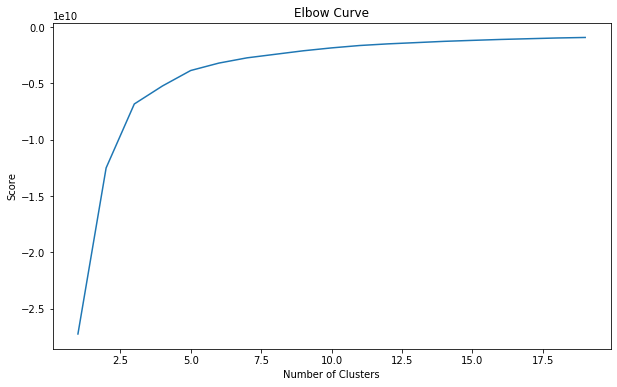

In [22]:
# plot Elbow curve to find best k value for kmeans
data = X1
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

 From the above elbow curve, we see that the graph levels off after 10 clusters, implying that addition of more clusters do not explain much more of the variance in our relevant variable;

# Kmeans Clustering

In [23]:
# kmeans clasturing with k=10
X1 = X1.reset_index(drop=True)
km = KMeans(n_clusters=10)
km.fit(X1)
labels = km.labels_

In [24]:
# prediction with kmean
def predict(X, y, model):
    y_predict = model.predict(X)
    X = X.compute()
    X["label"] = y_predict    
    y["label"] = y_predict
    return X ,y    
    

In [25]:
X1.head()

,price,los,leadTime,occupancy,month,day_of_week,day_of_month,isCancelable,roomType_Deluxe Apartment,roomType_Doppelzimmer,roomType_Studio-Apartment,roomType_Apartment mit Küche/Balkon,roomType_Maisonette-Apartment,mealPlan_RoomOnly,mealPlan_InclBreakfast
0,210.61,1,0,3,12,1,17,1,1,0,0,0,0,1,0
1,494.00,1,0,3,12,1,17,1,0,1,0,0,0,0,1
2,449.00,1,0,3,12,1,17,1,0,1,0,0,0,1,0
3,429.00,1,0,2,12,1,17,1,0,1,0,0,0,0,1
4,399.00,1,0,2,12,1,17,1,0,1,0,0,0,1,0


In [26]:
X1.shape

(Delayed('int-03efc64b-03b0-4234-b0d4-5955fceaebc0'), 15)

# Cluster all Hotels

In this section, I use information of all Hotels in Berlin and devide them in 10 clusters that detected in previous 
section by kmeans.

In [27]:
#read data by dask
df2 = dd.read_csv("clean_data_1394_berlin.csv").head(n=1000000)
df2.head()

,rid,bid,city,price_m2,rooms_available,pax,breakfast,free_cancel,part_refund,no_prepay,...,fcty_elevator,fcty_shuttle,fcty_beach,fcty_garden,fcty_24h_rec,fcty_maid,fcty_laundry,fcty_pool,min_pax,max_pax
0,6175940,61759,berlin,4.304348,8,1,t,f,t,f,...,f,f,f,f,f,f,f,f,1,2
1,6929041,69290,berlin,0.000000,6,1,t,t,f,t,...,f,f,f,f,f,f,f,f,1,3
2,6049003,60490,berlin,3.863636,6,3,t,f,t,f,...,f,f,f,f,f,f,f,f,3,3
3,2541806,25418,berlin,4.050000,4,1,f,t,f,t,...,f,f,f,f,f,f,f,f,1,2
4,6019404,60194,berlin,4.580000,11,2,t,f,f,f,...,f,f,f,f,f,f,f,f,1,2


In [28]:
df2.columns

Index(['rid', 'bid', 'city', 'price_m2', 'rooms_available', 'pax', 'breakfast',
       'free_cancel', 'part_refund', 'no_prepay', 'no_refund', 'collected',
       'checkin', 'checkout', 'jid', 'sqm', 'total_price', 'hotel_group',
       'hotel_type', 'lux', 'single', 'double', 'big', 'budget', 'hotel_name',
       'district', 'lat', 'lon', 'review_count', 'stars_type', 'stars',
       'rvw_clean', 'rvw_location', 'rvw_staff', 'rvw_comfort', 'rvw_value',
       'rvw_facilities', 'rvw_wifi', 'rvw_total', 'fcty_heat', 'fcty_wifi',
       'fcty_roomservice', 'fcty_parking', 'fcty_nonsmoking', 'fcty_breakfast',
       'fcty_bar', 'fcty_pets', 'fcty_restaurant', 'fcty_spafit',
       'fcty_elevator', 'fcty_shuttle', 'fcty_beach', 'fcty_garden',
       'fcty_24h_rec', 'fcty_maid', 'fcty_laundry', 'fcty_pool', 'min_pax',
       'max_pax'],
      dtype='object')

In [29]:
df2 = df2[["rid", 'bid',"checkin", "checkout",
           'pax', 'breakfast','free_cancel', 'total_price','single', 
           'double', "big", "lux", "budget"]]

In [30]:
df2.head()

,rid,bid,checkin,checkout,pax,breakfast,free_cancel,total_price,single,double,big,lux,budget
0,6175940,61759,2020-05-24 00:00:00,2020-05-25 00:00:00,1,t,f,99.0,f,t,f,f,f
1,6929041,69290,2020-07-16 00:00:00,2020-07-18 00:00:00,1,t,t,0.0,f,f,f,t,f
2,6049003,60490,2020-06-13 00:00:00,2020-06-15 00:00:00,3,t,f,85.0,f,f,t,f,f
3,2541806,25418,2020-11-14 00:00:00,2020-11-15 00:00:00,1,f,t,162.0,f,f,f,t,f
4,6019404,60194,2020-08-01 00:00:00,2020-08-03 00:00:00,2,t,f,114.5,f,t,f,t,f


In [31]:
df1.head()

,hotelId,price,rateName,los,roomType,isCancelable,mealPlan,leadTime,occupancy,month,day_of_week,day_of_month
0,952,210.61,Deluxe Apartment mit 2 Schlafzimmern und Balko...,1,Deluxe Apartment,True,RoomOnly,0,3,12,1,17
1,39,494.00,Deluxe Suite - Stornierung Kostenfrei,1,Doppelzimmer,True,InclBreakfast,0,3,12,1,17
2,39,449.00,Deluxe Suite - Stornierung Kostenfrei,1,Doppelzimmer,True,RoomOnly,0,3,12,1,17
3,39,429.00,Deluxe Suite - Stornierung Kostenfrei,1,Doppelzimmer,True,InclBreakfast,0,2,12,1,17
4,39,399.00,Deluxe Suite - Stornierung Kostenfrei,1,Doppelzimmer,True,RoomOnly,0,2,12,1,17


In [32]:
#rename some columns in df2 equivalent df1
rename_dic = {"rid":"rateName", 'bid':"hotelId", "total_price":"price", 
              'pax':"occupancy","breakfast":"mealPlan", 'free_cancel':'isCancelable', 
              'total_price':"price"}
    
df2 = df2.rename(columns = rename_dic)

In [33]:
#convert to pandas
# df2 = df2.compute()

In [34]:
# values of mealPlan in df1
np.unique(df1.mealPlan)

array(['InclBreakfast', 'RoomOnly'], dtype=object)

In [35]:
# values of mealPlan in df2
np.unique(df2.mealPlan)

array(['f', 't'], dtype=object)

In [36]:
# rename values in df2 equivalent in df1
df2['mealPlan'] = df2['mealPlan'].replace({'t':'InclBreakfast', 'f':'RoomOnly'})


In [37]:
# rename values in df2 equivalent in df1
df2["isCancelable"] = df2['isCancelable'].replace({'t':1, 'f':0})


In [38]:
# long of stay
df2['checkin']= pd.to_datetime(df2.checkin)
df2['checkout']= pd.to_datetime(df2.checkin)
df2["los"] = (df2["checkout"] - df2["checkin"]).dt.days

In [39]:
# extract time information
df2["month"] = df2["checkin"].dt.month
df2["day_of_week"] = df2["checkin"].dt.dayofweek
df2["day_of_month"] = df2["checkin"].dt.day

In [40]:
# remove checkin and checkout after extracting time inf
df2 = df2.drop(["checkout", "checkin"],axis=1)

In [41]:
df2.head()

,rateName,hotelId,occupancy,mealPlan,isCancelable,price,single,double,big,lux,budget,los,month,day_of_week,day_of_month
0,6175940,61759,1,InclBreakfast,0,99.0,f,t,f,f,f,0,5,6,24
1,6929041,69290,1,InclBreakfast,1,0.0,f,f,f,t,f,0,7,3,16
2,6049003,60490,3,InclBreakfast,0,85.0,f,f,t,f,f,0,6,5,13
3,2541806,25418,1,RoomOnly,1,162.0,f,f,f,t,f,0,11,5,14
4,6019404,60194,2,InclBreakfast,0,114.5,f,t,f,t,f,0,8,5,1


In [42]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107601 entries, 0 to 107600
Data columns (total 15 columns):
rateName        107601 non-null int64
hotelId         107601 non-null int64
occupancy       107601 non-null int64
mealPlan        107601 non-null object
isCancelable    107601 non-null int64
price           107601 non-null float64
single          107601 non-null object
double          107601 non-null object
big             107601 non-null object
lux             107601 non-null object
budget          107601 non-null object
los             107601 non-null int64
month           107601 non-null int64
day_of_week     107601 non-null int64
day_of_month    107601 non-null int64
dtypes: float64(1), int64(8), object(6)
memory usage: 12.3+ MB


In [43]:
df2["leadTime"]=1

In [44]:
# split data, hotelId+rateName are used to identify each room
y2 = df2[["hotelId", "rateName"]]
X2 = df2.drop(["hotelId", "rateName"], axis=1)

In [45]:
X2.shape

(107601, 14)

In [46]:
X2.columns

Index(['occupancy', 'mealPlan', 'isCancelable', 'price', 'single', 'double',
       'big', 'lux', 'budget', 'los', 'month', 'day_of_week', 'day_of_month',
       'leadTime'],
      dtype='object')

In [47]:
# rename valuse in df2 equivalent df1
X2["lux"] = X2["lux"].replace({'t':1, 'f':0})
X2["big"] = X2["big"].replace({'t':1, 'f':0})
X2["single"] = X2["single"].replace({'t':1, 'f':0})
X2["double"] = X2["double"].replace({'t':1, 'f':0})
X2["budget"] = X2["budget"].replace({'t':1, 'f':0})


In [48]:
X2.head()

,occupancy,mealPlan,isCancelable,price,single,double,big,lux,budget,los,month,day_of_week,day_of_month,leadTime
0,1,InclBreakfast,0,99.0,0,1,0,0,0,0,5,6,24,1
1,1,InclBreakfast,1,0.0,0,0,0,1,0,0,7,3,16,1
2,3,InclBreakfast,0,85.0,0,0,1,0,0,0,6,5,13,1
3,1,RoomOnly,1,162.0,0,0,0,1,0,0,11,5,14,1
4,2,InclBreakfast,0,114.5,0,1,0,1,0,0,8,5,1,1


In [49]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107601 entries, 0 to 107600
Data columns (total 14 columns):
occupancy       107601 non-null int64
mealPlan        107601 non-null object
isCancelable    107601 non-null int64
price           107601 non-null float64
single          107601 non-null int64
double          107601 non-null int64
big             107601 non-null int64
lux             107601 non-null int64
budget          107601 non-null int64
los             107601 non-null int64
month           107601 non-null int64
day_of_week     107601 non-null int64
day_of_month    107601 non-null int64
leadTime        107601 non-null int64
dtypes: float64(1), int64(12), object(1)
memory usage: 11.5+ MB


In [50]:
# rename featurs in df2 equivalent df1
rename_dic = {'lux':'roomType_Deluxe Apartment',
       "double":'roomType_Doppelzimmer', 'single':'roomType_Studio-Apartment',
       'budget':'roomType_Apartment mit Küche/Balkon', 'big':'roomType_Maisonette-Apartment'}
X2 = X2.rename(columns = rename_dic)

In [51]:
# encode categorical variable
X2 = encode_cat_df(X2)

Index(['mealPlan'], dtype='object')
Index(['occupancy', 'isCancelable', 'price', 'roomType_Studio-Apartment',
       'roomType_Doppelzimmer', 'roomType_Maisonette-Apartment',
       'roomType_Deluxe Apartment', 'roomType_Apartment mit Küche/Balkon',
       'los', 'month', 'day_of_week', 'day_of_month', 'leadTime'],
      dtype='object')


In [52]:
# predice label of each data for all hotels
X2_labeled , y2 = predict(X2,y2, km)


In [53]:
X2_labeled.head()

,occupancy,isCancelable,price,roomType_Studio-Apartment,roomType_Doppelzimmer,roomType_Maisonette-Apartment,roomType_Deluxe Apartment,roomType_Apartment mit Küche/Balkon,los,month,day_of_week,day_of_month,leadTime,mealPlan_InclBreakfast,mealPlan_RoomOnly,label
0,1,0,99.0,0,1,0,0,0,0,5,6,24,1,1,0,3
1,1,1,0.0,0,0,0,1,0,0,7,3,16,1,1,0,9
2,3,0,85.0,0,0,1,0,0,0,6,5,13,1,1,0,3
3,1,1,162.0,0,0,0,1,0,0,11,5,14,1,0,1,3
4,2,0,114.5,0,1,0,1,0,0,8,5,1,1,1,0,3


In [54]:
# predice label of each data for 10 hotels
y1 = y1.compute()
X1_labeled, y1 = predict(X1, y1, km)


In [55]:
# merge all data
X_labeled = dd.concat([X1_labeled, X2_labeled], axis=0)

In [56]:
y = dd.concat([y1, y2], axis=0)

In [57]:
y1.head()

,hotelId,rateName,label
0,952,Deluxe Apartment mit 2 Schlafzimmern und Balko...,0
1,39,Deluxe Suite - Stornierung Kostenfrei,2
2,39,Deluxe Suite - Stornierung Kostenfrei,2
3,39,Deluxe Suite - Stornierung Kostenfrei,2
4,39,Deluxe Suite - Stornierung Kostenfrei,2


In [58]:
df_labeled = dd.concat([X_labeled["label"], y], axis=0)

In [59]:
# split all data between clusters
clus_y={}
clus={}
for i in range(10):
    clus[i] = X_labeled[X_labeled.label==i]
    clus_y[i] = y[y.label==i]


In [60]:
y.compute().shape

(1091906, 3)

# Recommender System

In this section, after prediction of cluster of input data, distance between input and its all member of
that cluster is calculated.

In [61]:
# calculate distance between each input value and cluster
def getDistanceByPoint(cluster, data):
#     distance = pd.Series(index)
    distance = []
    for i in range(cluster.compute().shape[0]):
        Xa = np.array(cluster.loc[i])
        Xb = np.array(data.loc[0])
        distance.append(np.linalg.norm(Xa-Xb))
#         print(Xb)

#         distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

In [72]:
# 
def recommenender(input_data):
    data = pd.DataFrame.from_dict(input_data)
    
    data['targetDate']= pd.to_datetime(data.targetDate)
    data["month"] = data["targetDate"].dt.month
    data["day_of_week"] = data["targetDate"].dt.dayofweek
    data["day_of_month"] = data["targetDate"].dt.day
    data = data.drop("targetDate", axis=1)
    
#     encoded_df = encode_cat_df(data)
    
    y_predict = km.predict(data)
    label = y_predict[0]
#     label = 1
    data["label"] = label
    print(label)

    cluster = clus[label]
    print(cluster.shape)
    distance = getDistanceByPoint(cluster, data)
    clus_y[label] = clus_y[label].compute()
    clus_y[label]["dis"]= distance
    return clus_y[label]
    


# Sample Work

In [67]:
# get information from user
print("please choose your option for a room")
input_data ={}
input_data["price"] = [input("Enter price:")]
input_data["los"] = [input("how many days you stay")]
input_data["occupancy"] = [input("how many people")]
# input_data['targetDate'] = input("when will you arrive (sample: 12-03-2019)")
input_data['targetDate'] = '10-03-2019'
input_data["isCancelable"] =[input("please enter 1 for cancelfree and 0 for ")]
input_data['roomType_Deluxe Apartment'] = [input("please choose type of room: Deluxe Apartment(0 or 1)")]
input_data['roomType_Studio-Apartment'] = [input("please choose type of room: Studio-Apartment (0 or 1)")]
input_data['roomType_Doppelzimmer'] = [input("please choose type of room: Doppelzimmer (0 or 1)")]
input_data['roomType_Apartment mit Küche/Balkon'] = [input("please choose type of room:Apartment mit Küche/Balkon (0 or 1)")]
input_data['roomType_Maisonette-Apartment'] = [input("please choose type of room: Maisonette-Apartment (0 or 1)")]
input_data['mealPlan_RoomOnly'] = [input("RoomOnly")]
input_data['mealPlan_InclBreakfast'] = [input("InclBreakfast")]
input_data["leadTime"]:[1]


please choose your option for a room
Enter price:200
how many days you stay1
how many people3
please enter 1 for cancelfree and 0 for 0
please choose type of room: Deluxe Apartment(0 or 1)0
please choose type of room: Studio-Apartment (0 or 1)0
please choose type of room: Doppelzimmer (0 or 1)0
please choose type of room:Apartment mit Küche/Balkon (0 or 1)0
please choose type of room: Maisonette-Apartment (0 or 1)1
RoomOnly0
InclBreakfast1


In [68]:
input_data

{'price': ['200'],
 'los': ['1'],
 'occupancy': ['3'],
 'targetDate': '10-03-2019',
 'isCancelable': ['0'],
 'roomType_Deluxe Apartment': ['0'],
 'roomType_Studio-Apartment': ['0'],
 'roomType_Doppelzimmer': ['0'],
 'roomType_Apartment mit Küche/Balkon': ['0'],
 'roomType_Maisonette-Apartment': ['1'],
 'mealPlan_RoomOnly': ['0'],
 'mealPlan_InclBreakfast': ['1']}

In [69]:
input_data2 = {'price':[200], 
              'los':[1], 
              'leadTime':[1],
              'occupancy':[3],
              "targetDate":"12-03-2019",
              'isCancelable':[0],
              'roomType_Deluxe Apartment':[0],
              'roomType_Doppelzimmer':[0],
              'roomType_Studio-Apartment':[0],
              'roomType_Apartment mit Küche/Balkon':[0],
              'roomType_Maisonette-Apartment':[1],
              'mealPlan_RoomOnly':[0],
              'mealPlan_InclBreakfast':[1]}

In [73]:
recom = recommenender(input_data2)



1
(Delayed('int-3230d3d1-fb6a-4687-ab44-f2349582f8a4'), 16)


In [74]:
recom.sort_values(by="dis")

,hotelId,rateName,label,dis
278,5503,Penthouse-Suite mit 3 Schlafzimmern - Stornier...,1,0.000000
210791,5503,Penthouse-Suite mit 2 Schlafzimmern - Stornier...,1,0.000000
210790,5503,Penthouse-Suite mit 3 Schlafzimmern - Nicht ko...,1,0.000000
210789,5503,Penthouse-Suite mit 3 Schlafzimmern - Stornier...,1,0.000000
210779,5503,Penthouse-Suite mit 2 Schlafzimmern - Stornier...,1,0.000000
...,...,...,...,...
293876,5503,Penthouse-Suite mit 2 Schlafzimmern - Stornier...,1,1381.679051
41085,5503,Penthouse-Suite mit 3 Schlafzimmern - Nicht ko...,1,1430.346811
158817,5503,Penthouse-Suite mit 3 Schlafzimmern - Stornier...,1,1430.346811
293638,5503,Penthouse-Suite mit 2 Schlafzimmern - Stornier...,1,1430.346811


Each (HotelId + rateName) can use for as a suggestion to user 

# Future Work

There are some important points to enhance model’s performance 
and accuracy such as:

* Improve Feature selection
* GridSearch and Hyper parameter Optimization
* Semantic analysis for rateName feature
* Using Deep learning model

Here in this work, due to time constraints, little attention has been paid and Further investigation should be undertaken. 